![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Final Project: Contextual Bandits - Algorithm Analysis*

## Reinforcement Learning

#### Authors: **Timothy Cassel, Marvin Ernst, Oliver Tausendschön**

Date: July 2, 2025

Instructors: *Hamish Flynn and Vincent Adam*

In this notebook, we evaluate and analyze contextual bandit algorithms using the **Open Bandit Dataset (OBD)**. The main focus lies on implementing and benchmarking **Thompson Sampling (TS)** variants under realistic logged feedback conditions.

We perform the following:
- Implement **Thompson Sampling for linear bandits** using Bayesian linear regression
- Compare TS to **LinUCB** and **Random** policies
- Evaluate offline performance using:
  - **Inverse Propensity Scoring (IPS)**
  - **Doubly Robust (DR)** estimators
- Assess exploration behavior and learning stability
 
This notebook provides additional insights into the empirical behavior of Bayesian bandit strategies and whether **TS** can outperform **UCB** in sparse, realistic environments.

---

## 1. Setup and Imports

Importing the relevant libraries:

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
import random
import os
from linucb import linucb_all

Set seeds for reproducibility:

In [20]:
np.random.seed(42)
random.seed(42)

## 2. Load Processed Data

(We have the preprocessed version in `processed_top3/`)

In [21]:
X_context = np.load("processed_top3/context_reduced.npy")
actions = np.load("processed_top3/actions.npy")
rewards = np.load("processed_top3/rewards.npy")
pscores = np.load("processed_top3/pscores.npy")
meta = np.genfromtxt("processed_top3/meta.txt", skip_header=1)

n_rounds, context_dim = X_context.shape
n_arms = len(np.unique(actions))

print(f"Context shape: {X_context.shape}, #Arms: {n_arms}")

Context shape: (53988, 12), #Arms: 3


## 3. Re-run LinUCB 

We use this for comparison to the TS version.

In [22]:
alpha = 1.0
A = [np.identity(X_context.shape[1]) for _ in range(n_arms)]
b = [np.zeros(X_context.shape[1]) for _ in range(n_arms)]

results = linucb_all(X_context, actions, rewards, A, b, alpha)

## 4. Thompson Sampling with Linear Models

We now implement **contextual Thompson Sampling (TS)** using a Bayesian linear regression formulation.

TS maintains a posterior distribution over the weight vector $\theta_a$ for each arm and samples from this distribution to select actions. In each round, it draws a sample $\tilde{\theta}_a$ for each arm, computes the estimated reward $\tilde{r}_a = x^\top \tilde{\theta}_a$, and selects the arm with the highest sampled reward.

This stochastic action selection naturally balances **exploration** (sampling new parameters) and **exploitation** (choosing high-reward arms).

We evaluate the standard TS algorithm with ridge priors:
- Prior: $\theta_a \sim \mathcal{N}(0, \lambda^{-1} I)$
- Posterior updated using ridge regression

After running the TS policy, we use the **Doubly Robust (DR)** estimator to compare its performance against LinUCB.

In [23]:
def ts_linear_all(contexts, actions, rewards, alpha=1.0, lambda_prior=1.0):
    n_rounds, context_dim = contexts.shape
    n_actions = len(np.unique(actions))

    A = [lambda_prior * np.identity(context_dim) for _ in range(n_actions)]
    b = [np.zeros(context_dim) for _ in range(n_actions)]

    chosen_actions = []
    theta_samples = []

    for t in range(n_rounds):
        x = contexts[t]
        sampled_thetas = []

        for a in range(n_actions):
            A_inv = np.linalg.inv(A[a])
            mu = A_inv @ b[a]
            cov = alpha**2 * A_inv  # scale variance by alpha
            theta_sample = np.random.multivariate_normal(mu, cov)
            sampled_thetas.append(theta_sample)

        rewards_hat = [x @ theta for theta in sampled_thetas]
        chosen_action = np.argmax(rewards_hat)

        # update only if action matches the logged one
        if chosen_action == actions[t]:
            A[chosen_action] += np.outer(x, x)
            b[chosen_action] += rewards[t] * x

        chosen_actions.append(chosen_action)
        theta_samples.append(sampled_thetas)

    return {
        "chosen_actions": chosen_actions,
        "theta_samples": theta_samples,
        "rewards": rewards,
        "true_actions": actions,
    }

## 5. Evaluate Thompson Sampling (DR)

We now evaluate the TS policy using the **Doubly Robust estimator**, consistent with our previous LinUCB analysis.

This enables fair comparison, particularly under sparse and partial feedback conditions.

In [24]:
ts_results = ts_linear_all(X_context, actions, rewards, alpha=1.0)

Ensuring reward_model and action_onehot are trained:

In [25]:
a_logged = np.array(actions)
r_logged = np.array(rewards)

action_onehot = OneHotEncoder(sparse_output=False)
a_logged_1hot = action_onehot.fit_transform(a_logged.reshape(-1, 1))

X_train = np.hstack([X_context, a_logged_1hot])
reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
reward_model.fit(X_train, r_logged)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Predict rewards for TS actions:

In [26]:
a_ts = np.array(ts_results["chosen_actions"])
a_ts_1hot = action_onehot.transform(a_ts.reshape(-1, 1))
X_ts = np.hstack([X_context, a_ts_1hot])
r_hat_ts = reward_model.predict(X_ts)

DR correction:

In [27]:
matches_ts = a_ts == actions
correction_ts = np.zeros_like(rewards)
correction_ts[matches_ts] = (rewards[matches_ts] - r_hat_ts[matches_ts]) / pscores[matches_ts]
dr_estimates_ts = r_hat_ts + correction_ts
cumulative_dr_ts = np.cumsum(dr_estimates_ts)

**LinUCB evaluation**

In [28]:
a_linucb = np.array(results["chosen_actions"])
a_linucb_1hot = action_onehot.transform(a_linucb.reshape(-1, 1))
X_linucb = np.hstack([X_context, a_linucb_1hot])
r_hat_linucb = reward_model.predict(X_linucb)

matches_linucb = a_linucb == a_logged
correction_linucb = np.zeros_like(r_logged)
correction_linucb[matches_linucb] = (r_logged[matches_linucb] - r_hat_linucb[matches_linucb]) / pscores[matches_linucb]
dr_estimates = r_hat_linucb + correction_linucb
cumulative_dr = np.cumsum(dr_estimates)

For DM baseline:

In [30]:
a_logged_1hot = action_onehot.transform(a_logged.reshape(-1, 1))
X_dm = np.hstack([X_context, a_logged_1hot])
r_hat_dm = reward_model.predict(X_dm)
cumulative_dm_random = np.cumsum(r_hat_dm)

**True Baseline**

We simulate a new random policy:

In [35]:
np.random.seed(123)
random_actions = np.random.randint(0, n_arms, size=len(X_context))

We predict rewards for the random policy:

In [36]:
random_actions_1hot = action_onehot.transform(random_actions.reshape(-1, 1))
X_random = np.hstack([X_context, random_actions_1hot])
r_hat_random_eval = reward_model.predict(X_random)

DR Correction:

In [37]:
matches_random = random_actions == a_logged
correction_random = np.zeros_like(r_logged)
correction_random[matches_random] = (r_logged[matches_random] - r_hat_random_eval[matches_random]) / pscores[matches_random]
dr_random_eval = r_hat_random_eval + correction_random
cumulative_random_eval = np.cumsum(dr_random_eval)

**Comparison**

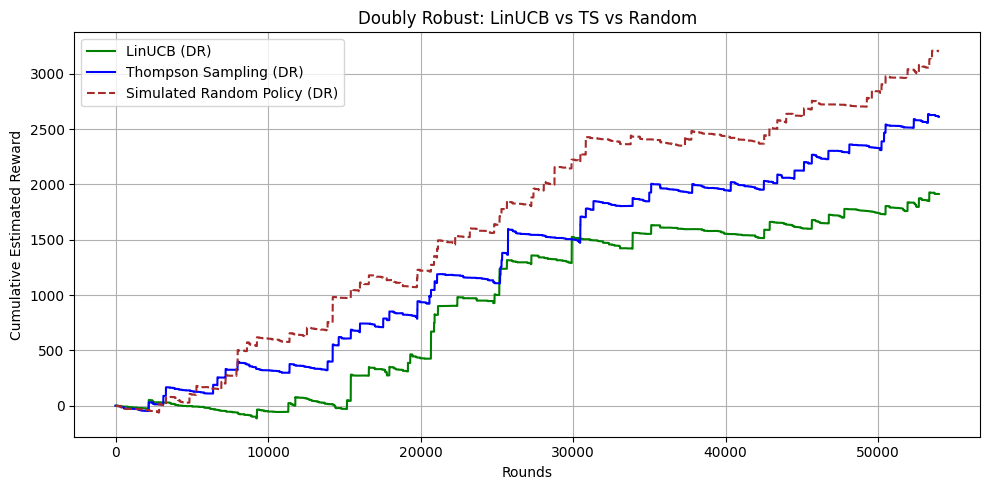

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(cumulative_dr, label="LinUCB (DR)", color="green")
plt.plot(cumulative_dr_ts, label="Thompson Sampling (DR)", color="blue")
plt.plot(cumulative_random_eval, label="Simulated Random Policy (DR)", linestyle="--", color="brown")
plt.title("Doubly Robust: LinUCB vs TS vs Random")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We see that in a single run, **Thompson Sampling (TS)** appears to outperform **LinUCB**, even though both perform worse than the **simulated random policy** when evaluated using the **Doubly Robust (DR)** estimator.

In particular, **LinUCB with $\alpha = 1.0$** performs significantly worse, highlighting that strong exploration is detrimental in this sparse reward environment. However, **TS still fails to beat the random baseline**, which limits its practical promise.

### 6. Averaged Evaluation over 30 Simulations

To reduce the variance of single-run evaluations, we now compare LinUCB and Thompson Sampling (TS) under multiple exploration parameters across **30 randomized runs**.

For each run, we:
- Shuffle the context-action-reward dataset
- Train a fresh reward model (Random Forest)
- Apply **Doubly Robust (DR)** estimation to evaluate each policy

We include:
- **LinUCB** with $\alpha \in \{0.0, 0.1, 0.25\}$
- **Thompson Sampling (TS)** with $\alpha \in \{0.25, 0.5, 1.0\}$
- A **simulated random policy** (uniform arm selection)

Each policy's **cumulative reward curve** is averaged across all runs.

> Note: Unlike in LinUCB where $\alpha = 0$ implies purely greedy behavior, in TS, $\alpha = 0$ is invalid. Instead, it controls posterior variance: larger $\alpha$ implies greater randomness in sampling.

This evaluation allows a more stable and fair comparison between deterministic and stochastic exploration strategies in contextual bandits.

In [39]:
n_runs = 30
n_rounds = len(X_context)
context_dim = X_context.shape[1]

Define LinUCB and TS alpha values:

In [40]:
linucb_alphas = [0.0, 0.1, 0.25]
ts_alphas = [0.25, 0.5, 1.0]

Init average curves and loop throutgh the evaluations:

In [41]:
all_labels = [f"LinUCB alpha={a}" for a in linucb_alphas] + [f"TS alpha={a}" for a in ts_alphas] + ["Simulated Random Policy"]
average_curves = {label: np.zeros(n_rounds) for label in all_labels}

for seed in range(n_runs):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n_rounds)

    # Shuffle data
    X = X_context[idx]
    a_logged = actions[idx]
    r_logged = rewards[idx]
    p = pscores[idx]

    # Fit reward model
    onehot = OneHotEncoder(sparse_output=False)
    a_1hot = onehot.fit_transform(a_logged.reshape(-1, 1))
    X_train = np.hstack([X, a_1hot])

    reward_model = RandomForestRegressor(n_estimators=100, random_state=seed)
    reward_model.fit(X_train, r_logged)

    # LinUCB
    for alpha in linucb_alphas:
        A = [np.identity(context_dim) for _ in range(n_arms)]
        b = [np.zeros(context_dim) for _ in range(n_arms)]
        res = linucb_all(X, a_logged, r_logged, A, b, alpha)
        a_eval = np.array(res["chosen_actions"])
        a_eval_1hot = onehot.transform(a_eval.reshape(-1, 1))
        X_eval = np.hstack([X, a_eval_1hot])
        r_hat = reward_model.predict(X_eval)

        match = a_eval == a_logged
        corr = np.zeros_like(r_logged)
        corr[match] = (r_logged[match] - r_hat[match]) / p[match]
        dr = r_hat + corr

        average_curves[f"LinUCB alpha={alpha}"] += np.cumsum(dr)

    # TS 
    for alpha in ts_alphas:
        ts_res = ts_linear_all(X, a_logged, r_logged, alpha=alpha)
        a_ts = np.array(ts_res["chosen_actions"])
        a_ts_1hot = onehot.transform(a_ts.reshape(-1, 1))
        X_ts = np.hstack([X, a_ts_1hot])
        r_hat_ts = reward_model.predict(X_ts)

        match_ts = a_ts == a_logged
        corr_ts = np.zeros_like(r_logged)
        corr_ts[match_ts] = (r_logged[match_ts] - r_hat_ts[match_ts]) / p[match_ts]
        dr_ts = r_hat_ts + corr_ts

        average_curves[f"TS alpha={alpha}"] += np.cumsum(dr_ts)

    # Simulated Random Policy 
    a_sim = rng.integers(0, n_arms, size=n_rounds)
    a_sim_1hot = onehot.transform(a_sim.reshape(-1, 1))
    X_sim = np.hstack([X, a_sim_1hot])
    r_hat_sim = reward_model.predict(X_sim)

    match_sim = a_sim == a_logged
    corr_sim = np.zeros_like(r_logged)
    corr_sim[match_sim] = (r_logged[match_sim] - r_hat_sim[match_sim]) / p[match_sim]
    dr_sim = r_hat_sim + corr_sim

    average_curves["Simulated Random Policy"] += np.cumsum(dr_sim)

Normalize by number of runs:

In [42]:
for label in average_curves:
    average_curves[label] /= n_runs

**Investiagting Matches with the Logged Actions**

We already saw differences in Rewards, copmared to the previous notebook, this is because DR is evaluated now on TS. And there are likely to be more matches.

For the random policy:

In [ ]:
np.mean(random_actions == actions) 

0.3344632140475661

For LinUCB:

In [45]:
np.mean(a_linucb == actions)         # match rate for LinUCB

0.25162999185004076

For LinTS:

In [ ]:
np.mean(a_ts == actions) 

0.3301659628065496

- TS and Simulated Random overlap 1 out of 3 times with the logged policy - as expected under uniform randomness across 3 arms.
- LinUCB overlaps significantly less because it’s structured, not random.

Even though about 25% sounds decent, it still means:
- 75% of the time, LinUCB’s actions get no reward signal under DR.
- So the DR estimator is blind to most of what LinUCB is doing - particularly when it’s greedy or $\alpha$ is low.

**Consequence for DR Evaluation:**

- More matches means better DR correction, thus higher estimated reward
- That’s why TS (being stochastic) often looks better even if it might not be in an online setting.

**Comparison**

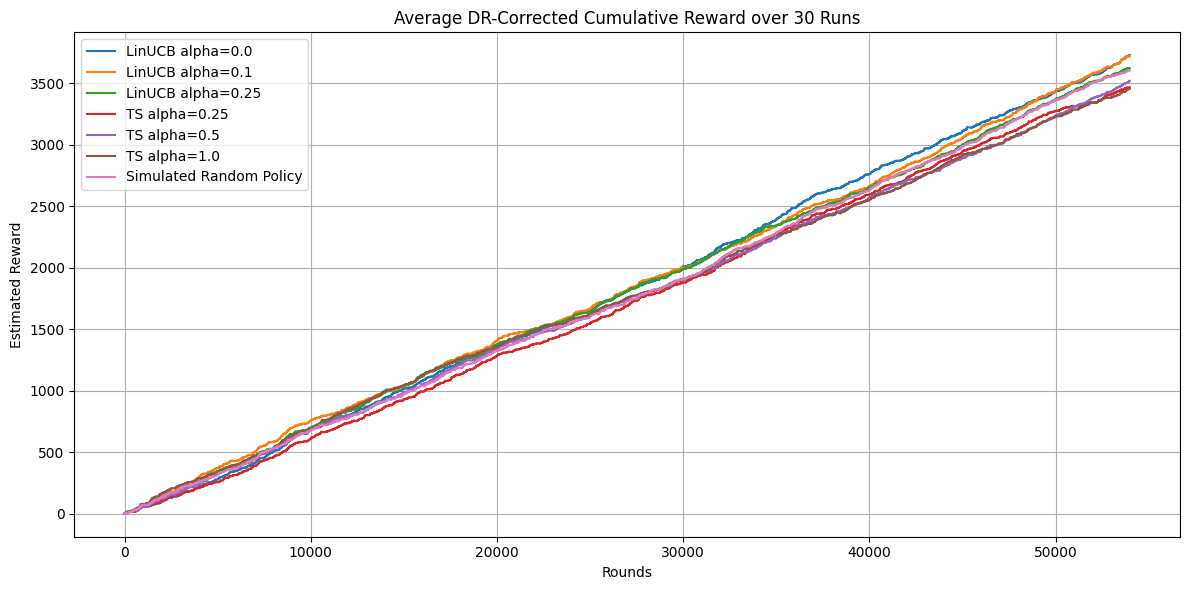

In [43]:
plt.figure(figsize=(12, 6))
for label, curve in average_curves.items():
    plt.plot(curve, label=label)
plt.title("Average DR-Corrected Cumulative Reward over 30 Runs")
plt.xlabel("Rounds")
plt.ylabel("Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From this we can see ...





## 7. Varying Prior Strength: Different $\lambda$ for Best-Performing TS Variant

In addition to tuning the exploration factor $\alpha$, we now explore how the **prior strength parameter** $\lambda$ affects Thompson Sampling (TS) performance.

We fix the best-performing configuration from earlier - namely **TS with $\alpha = 0.5$** - and evaluate the effect of varying $\lambda$ across:

- $\lambda = 0.1$ (very weak prior)
- $\lambda = 1.0$ (default prior used in earlier experiments)
- $\lambda = 10.0$ (strong prior)

Recall that TS maintains a Bayesian posterior over arm-specific regression weights:

$$
\theta_a \sim \mathcal{N}(\mu_a, \Sigma_a) \quad \text{with} \quad \Sigma_a = \alpha^2 A_a^{-1}, \quad A_a = \lambda I + \sum_{i \in \mathcal{D}_a} x_i x_i^\top
$$

Thus, $\lambda$ controls how **confident** the model is in its prior:
- Smaller $\lambda$: more flexible, faster to adapt (but higher variance)
- Larger $\lambda$: more stable, more prior-conservative

We average DR-corrected cumulative rewards over **30 random permutations** of the dataset and compare:

- Each TS variant with different $\lambda$
- **LinUCB ($\alpha = 0.0$)** - the best UCB variant
- **Simulated Random Policy (DR)** - baseline

In [48]:
n_runs = 30
n_rounds = len(X_context)
context_dim = X_context.shape[1]
fixed_alpha = 0.5
lambda_vals = [0.1, 10.0]

Initialize result containers and loop throutgh the evaluations:

In [49]:
ts_lambda_curves = {f"TS alpha={fixed_alpha}, lambda={lam}": np.zeros(n_rounds) for lam in lambda_vals}
ts_lambda_curves["TS alpha=0.5, lambda=1.0"] = average_curves["TS alpha=0.5"]
linucb_greedy_curve = np.zeros(n_rounds)
random_sim_curve = np.zeros(n_rounds)

for seed in range(n_runs):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n_rounds)

    X = X_context[idx]
    a_logged = actions[idx]
    r_logged = rewards[idx]
    p = pscores[idx]

    # Reward model
    onehot = OneHotEncoder(sparse_output=False)
    a_1hot = onehot.fit_transform(a_logged.reshape(-1, 1))
    X_train = np.hstack([X, a_1hot])

    reward_model = RandomForestRegressor(n_estimators=100, random_state=seed)
    reward_model.fit(X_train, r_logged)

    # Evaluate TS variants
    for lam in lambda_vals:
        label = f"TS alpha={fixed_alpha}, lambda={lam}"
        ts_res = ts_linear_all(X, a_logged, r_logged, alpha=fixed_alpha, lambda_prior=lam)
        a_ts = np.array(ts_res["chosen_actions"])
        a_ts_1hot = onehot.transform(a_ts.reshape(-1, 1))
        X_ts = np.hstack([X, a_ts_1hot])
        r_hat_ts = reward_model.predict(X_ts)

        match_ts = a_ts == a_logged
        corr_ts = np.zeros_like(r_logged)
        corr_ts[match_ts] = (r_logged[match_ts] - r_hat_ts[match_ts]) / p[match_ts]
        dr_ts = r_hat_ts + corr_ts

        ts_lambda_curves[label] += np.cumsum(dr_ts)

    # LinUCB alpha = 0.0
    A = [np.identity(context_dim) for _ in range(n_arms)]
    b = [np.zeros(context_dim) for _ in range(n_arms)]
    linucb_res = linucb_all(X, a_logged, r_logged, A, b, alpha=0.0)
    a_ucb = np.array(linucb_res["chosen_actions"])
    a_ucb_1hot = onehot.transform(a_ucb.reshape(-1, 1))
    X_ucb = np.hstack([X, a_ucb_1hot])
    r_hat_ucb = reward_model.predict(X_ucb)

    match_ucb = a_ucb == a_logged
    corr_ucb = np.zeros_like(r_logged)
    corr_ucb[match_ucb] = (r_logged[match_ucb] - r_hat_ucb[match_ucb]) / p[match_ucb]
    dr_ucb = r_hat_ucb + corr_ucb
    linucb_greedy_curve += np.cumsum(dr_ucb)

    # Simulated Random Policy (DR)
    a_sim = rng.integers(0, n_arms, size=n_rounds)
    a_sim_1hot = onehot.transform(a_sim.reshape(-1, 1))
    X_sim = np.hstack([X, a_sim_1hot])
    r_hat_sim = reward_model.predict(X_sim)

    match_sim = a_sim == a_logged
    corr_sim = np.zeros_like(r_logged)
    corr_sim[match_sim] = (r_logged[match_sim] - r_hat_sim[match_sim]) / p[match_sim]
    dr_sim = r_hat_sim + corr_sim
    random_sim_curve += np.cumsum(dr_sim)

KeyboardInterrupt: 

Normalize all:

In [ ]:
for k in ts_lambda_curves:
    ts_lambda_curves[k] /= n_runs
linucb_greedy_curve /= n_runs
random_sim_curve /= n_runs

**Comparison**

In [ ]:
plt.figure(figsize=(10, 5))
for label, curve in ts_lambda_curves.items():
    plt.plot(curve, label=label)
plt.plot(linucb_greedy_curve, label="LinUCB alpha=0.0 (greedy)", color="green", linestyle="--")
plt.plot(random_sim_curve, label="Simulated Random Policy (DR)", color="orange", linestyle=":")
plt.title("TS Performance by lambda (Fixed alpha=0.5)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative DR Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From this we can see ... 

In [52]:
# Run this in both notebooks
rng = np.random.default_rng(42)
a_sim = rng.integers(0, n_arms, size=n_rounds)

# Train reward model just once
reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
reward_model.fit(X_train, r_logged)

# Predict + DR
a_sim_1hot = onehot.transform(a_sim.reshape(-1, 1))
X_sim = np.hstack([X_context, a_sim_1hot])
r_hat_sim = reward_model.predict(X_sim)

matches = a_sim == a_logged
correction = np.zeros_like(r_logged)
correction[matches] = (r_logged[matches] - r_hat_sim[matches]) / pscores[matches]
dr_sim = r_hat_sim + correction

print("DR reward mean for random policy:", dr_sim.mean())

DR reward mean for random policy: 0.06416830126676884


In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Fix seed, logging data
np.random.seed(123)
rng = np.random.default_rng(123)
a_logged = actions
r_logged = rewards
X = X_context
p = pscores

# One-hot encode
onehot = OneHotEncoder(sparse_output=False)
a_logged_1hot = onehot.fit_transform(a_logged.reshape(-1, 1))
X_train = np.hstack([X, a_logged_1hot])

# Train reward model with fixed seed
reward_model = RandomForestRegressor(n_estimators=100, random_state=123)
reward_model.fit(X_train, r_logged)

# Simulated random policy (fixed random actions)
a_sim = rng.integers(0, n_arms, size=len(X))
a_sim_1hot = onehot.transform(a_sim.reshape(-1, 1))
X_sim = np.hstack([X, a_sim_1hot])
r_hat_sim = reward_model.predict(X_sim)

matches = a_sim == a_logged
correction = np.zeros_like(r_logged)
correction[matches] = (r_logged[matches] - r_hat_sim[matches]) / p[matches]
dr_sim = r_hat_sim + correction

print("Fixed DR reward mean for random policy:", dr_sim.mean())

Fixed DR reward mean for random policy: 0.06645223966291249
